## 3) Interpretation - Prudential Life

## Importing Packages and loading into DF

In [1]:
from __future__ import print_function
import timeit

from sklearn.model_selection import learning_curve, ShuffleSplit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

%matplotlib inline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import sklearn.ensemble
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, mean_squared_error

import lime
import lime.lime_tabular

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
ins_data = './dataset/train.csv'
ins = pd.read_csv(ins_data)
# ins_test_data = './dataset/test.csv'
# ins_test = pd.read_csv(ins_test_data)

In [3]:
print(ins.shape)
# print(ins_test.shape)

(59381, 128)


## Cleaing Data
- Dropping Axis Column
- Creating dummy for column Product_Info_2 column
- Removing NaN values - where normally distributed, replacing with mean value, where other columns used meadian.

In [4]:
ins.drop('Id',axis=1,inplace=True)
# ins_test.drop('Id',axis=1,inplace=True)

In [5]:
ins.Product_Info_2.value_counts()
prod_2 = {'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,'A6':6,'A7':7,'A8':8,'B1':9,'B2':10,'C1':11,'C2':12,
          'C3':13,'C4':14,'D1':15,'D2':16,'D3':17,'D4':18,'E1':19}

ins.replace({"Product_Info_2": prod_2},inplace=True)

In [6]:
for i in range(2,6):
    ins['Family_Hist_%i' % i].fillna(0,inplace=True)
#     ins_test['Family_Hist_%i' % i].fillna(0,inplace=True)

for i in [1,10,15,24,32]:
    ins['Medical_History_%i' % i].fillna(0,inplace=True)
#     ins_test['Medical_History_%i' % i].fillna(0,inplace=True)

for i in [1,4,6]:
    ins['Employment_Info_%i' % i].fillna(0,inplace=True)
#     ins_test['Employment_Info_%i' % i].fillna(0,inplace=True)

ins['Insurance_History_5'].fillna(0,inplace=True)
# ins_test['Insurance_History_5'].fillna(0,inplace=True)

## Creating X and y for modelling

In [12]:
for i in ins.columns:
    if str(ins[i].dtypes) == 'int64':
        ins[i] = ins[i].astype('int8')
    else:
        ins[i] = ins[i].astype('float16')

In [13]:
features = ins.drop(['Response','Ht','Wt'],axis=1)
targets = ins.Response
targets = targets.map(lambda x: x-1)
X, X_holdout, y, y_holdout = train_test_split(features,targets, train_size = 0.8,test_size=0.2,random_state=77)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.9,test_size=0.1,random_state=50)

#### Determining Baseline

In [14]:
y_train.value_counts()

7    14028
5     8069
6     5821
1     4714
0     4489
4     3906
3     1003
2      723
Name: Response, dtype: int64

In [15]:
baseline=15637/len(y_train)
print(baseline)

0.36575211096297333


## XGBoost

In [16]:
xgb = XGBClassifier(n_estimators=100,max_depth=6,subsample=0.8,min_child_weight=5,eta=0.02,verbosity= 1,colsample_bytree=0.6,objective= 'multi:softprob',num_class= 8,gamma=5,reg_lambda=10,reg_alpha=6)
xgb.fit(X_train.values,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, eta=0.02, gamma=5,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=8, objective='multi:softprob',
       random_state=0, reg_alpha=6, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [17]:
scores= cross_val_score(xgb,X_train,y_train,cv=5,n_jobs=-1,verbose=1)
## calculate accuracy
accuracy_score_test = xgb.score(X_test.values,y_test)
accuracy_score_train = xgb.score(X_train.values,y_train)
## calculate log loss
y_pred = xgb.predict_proba(X_train.values)
log_loss_train = log_loss(y_train,y_pred)
y_pred = xgb.predict_proba(X_test.values)
log_loss_test = log_loss(y_test,y_pred)
## print values
print('baseline: ',baseline)
print("cv scores: ",scores)
print("mean cv scores: ",np.mean(scores))
print("std cv scores: ",np.std(scores))
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


baseline:  0.36575211096297333
cv scores:  [0.57563713 0.56863891 0.56419551 0.56357469 0.56868711]
mean cv scores:  0.5681466691401802
std cv scores:  0.004316388373630171
-------------------------------
accuracy score - train:  0.582157977217973
accuracy score - test:  0.5691433382445801
-------------------------------
log loss score - train:  1.191139159926662
log loss score - test:  1.2241117911896713


## Lime

Lime to look at the local explanation individual rows of data. For this, I have selected rows where the predictions were correct It is noted that the same top 5-8 features were shown in most cases. These were features were also shown to be in the top impacful features when implementing the SHAP modules (see bleow).

In [18]:
predict_fn_xgboost = lambda x: xgb.predict_proba(x).astype(float)

In [19]:
feature_names = []
for i in X_train.columns:
    feature_names.append(i)

print(feature_names)

['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'BMI', 'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_4', 'Employment_Info_5', 'Employment_Info_6', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_5', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_10', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_15', 'Medical_History_16'

In [20]:
int_col_num= []
int_col_name= []
flt_col_name = []
for i in range(0,len(X_train.columns)):
    if str(X_train.dtypes[i]) == 'int8':
        int_col_num.append(int(i))
        int_col_name.append(X_train.columns[i])
    else:
        flt_col_name.append(X_train.columns[i])

In [21]:
print(int_col_num)

[0, 1, 2, 4, 5, 6, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123]


In [22]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=feature_names,
                                                   class_names=['1','2','3','4','5','6','7','8'],
                                                   categorical_features=int_col_num,
                                                   categorical_names=int_col_name,
                                                   kernel_width=3)

C:\Users\Roy\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
C:\Users\Roy\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\Roy\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Roy\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [23]:
## create df with y Test and y pred and filter based on test. Look at correctly predicted vs incorrectly predicted ones.
y_pred = xgb.predict(X_test.values)
results = pd.DataFrame()
results['predicted'] = y_pred
results['actual'] = y_test

In [24]:
results[(results['actual']==7) & (results['predicted']==7)].head(20)

predicted  actual
27            7     7.0
309           7     7.0
397           7     7.0
529           7     7.0
580           7     7.0
641           7     7.0
645           7     7.0
869           7     7.0
930           7     7.0
935           7     7.0
1258          7     7.0
1363          7     7.0
1377          7     7.0
1391          7     7.0
1417          7     7.0
1463          7     7.0
1478          7     7.0
1570          7     7.0
1621          7     7.0
1725          7     7.0

In [25]:
ins.loc[27][['BMI',"Medical_Keyword_3","Product_Info_4","Medica_History_23","Medical_History_5",'Product_Info_2','Insured_Info_6']]

C:\Users\Roy\Anaconda3\lib\site-packages\pandas\core\series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


BMI                   0.296387
Medical_Keyword_3     0.000000
Product_Info_4        0.230713
Medica_History_23          NaN
Medical_History_5     1.000000
Product_Info_2       17.000000
Insured_Info_6             NaN
Name: 27, dtype: float16

In [26]:
# change observation_1 to change which row of data we look at using lime

observation_1 = 1314
exp = explainer.explain_instance(X_test.values[observation_1],predict_fn_xgboost, num_features=5)

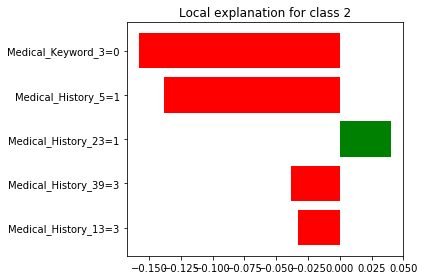

In [27]:
# This shows the explainer in a plot
exp.show_in_notebook(show_all=False)
exp.as_pyplot_figure()
plt.tight_layout()

## Shap

In [28]:
# second interpretation module looking at interpretation using Shapley values
import shap
shap.initjs() #java - needed to get below graphs working

In [29]:
ins_sample = ins.sample(n=500,random_state=100)
ins_sample_X = ins_sample.drop(['Response','Ht','Wt'],axis=1)
ins_sample_y = ins_sample['Response']

In [30]:
# explainer = shap.TreeExplainer(model,data=X_train,feature_dependence='independent')
# shap_values=explainer.shap_values(ins_sample_X)

In [36]:
explainer = shap.TreeExplainer(xgb)

In [37]:
shap_values=explainer.shap_values(ins_sample_X)

In [38]:
X_test_array=ins_sample_X.to_dense()

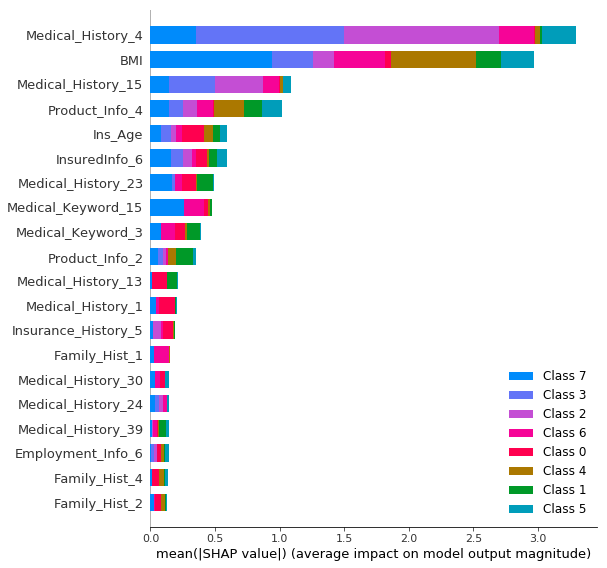

In [39]:
shap.summary_plot(shap_values,X_test_array,plot_type="bar")

In [46]:
shap.force_plot(explainer.expected_value[1], shap_values[1])

In [41]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], ins_sample_X.iloc[1,:], show=False)

In [45]:
shap.dependence_plot("BMI", shap_values, ins_sample_X)

AttributeError: 'list' object has no attribute 'shape'